[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Ware_et_al_2025/fig_6_7_8.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Ware_et_al_2025/fig_6_7_8.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Ware_et_al_2025/fig_6_7_8.ipynb)

# Figs 6, 7 & 8 in [Ware et al. 2025](https://doi.org/10.48550/arXiv.2509.05536)

In [1]:
import os, sys
os.environ['NUMBA_THREADING_LAYER'] = 'workqueue'  # PySDM & PyMPDATA don't work with TBB; OpenMP has extra dependencies on macOS
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples', 'PySDM')

In [2]:
os.environ['NUMBA_DISABLE_JIT'] = '1'  # Disable Numba JIT for CI testing

from PySDM_examples.Arabas_et_al_2015 import Settings, SpinUp
from PySDM_examples.utils.kinematic_2d import Simulation, Storage
from PySDM import Formulae
from PySDM.backends import CPU
from PySDM_examples.utils import ProgBarController
from PySDM import products as PySDM_products
from PySDM.physics import si
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ast

In [3]:
products = [
    PySDM_products.EffectiveRadius(name='r_eff_all',unit='um'),
    PySDM_products.ParticleConcentration(name="n_all"),
    PySDM_products.EffectiveRadius(radius_range=(40 * si.um, np.inf), name="r_gt_40um"),
    PySDM_products.WallTime(name='wall_time'),
    PySDM_products.LiquidWaterContent(name='lwc'),
    PySDM_products.CollisionTimestepMin(name='dt_min'),
    PySDM_products.CollisionRateDeficitPerGridbox(name='deficit'),
    PySDM_products.ParticleConcentration(radius_range=(40 * si.um, np.inf), name="n_gt_40um"),
    PySDM_products.CloudWaterContent(name='cwc',liquid=True,ice=False),
    PySDM_products.ActivatedParticleConcentration(name='n_act',count_activated=True,count_unactivated=False),
    PySDM_products.ActivatedEffectiveRadius(name='r_ef_act',count_activated=True,count_unactivated=False),
    PySDM_products.CollisionRatePerGridbox(name='crpgb'),
    PySDM_products.FlowVelocityComponent(component = 0, name = 'cx'),
    PySDM_products.FlowVelocityComponent(component = 1, name = 'cy'),
    PySDM_products.SurfacePrecipitation()
]

In [4]:
series = ['rainwater_massconc_timeseries',
'cloudwater_massconc_timeseries',
'all_liq_massconc_timeseries',
't_10_all_timeseries',
't_10_act_timeseries',
'minstep_timeseries',
'deficit_timeseries',
'fraction_of_affected_cells_timeseries']
loaded_data = {}

for series_name in series:
    filepath = f'{series_name}.json'
    if os.path.exists(filepath):
        with open(filepath,'r') as f:
            f = json.load(f)
        loaded_data[series_name] = {ast.literal_eval(k):v for k,v in f.items()}
    else:
        loaded_data[series_name] = {}

rainwater_massconc_timeseries = loaded_data['rainwater_massconc_timeseries']
cloudwater_massconc_timeseries = loaded_data['cloudwater_massconc_timeseries']
all_liq_massconc_timeseries = loaded_data['all_liq_massconc_timeseries']
t_10_all_timeseries = loaded_data['t_10_all_timeseries']
t_10_act_timeseries = loaded_data['t_10_act_timeseries']
minstep_timeseries = loaded_data['minstep_timeseries']
deficit_timeseries = loaded_data['deficit_timeseries']
fraction_of_affected_cells_timeseries = loaded_data['fraction_of_affected_cells_timeseries']

In [5]:
backend = CPU(formulae =Formulae())
runs = {}

/Users/emmaware/PySDM/PySDM/backends/numba.py:57: UserWarning: Disabling Numba threading due to ARM64 CPU (atomics do not work yet)
  warnings.warn(


##### 1. run a simulations saving output to VTK files

In [6]:
dts = [5,6,10]
nxs = [50]
sd_per_grid = [256]
iters = 40

for j in range(iters):
    for nx in nxs:
            for dt in dts:
                for nsd_per in sd_per_grid:
                    for i in range(2):
                        if (dt,j, 'adaptive') and (dt,j,'fixed') in rainwater_massconc_timeseries:
                            continue
                        settings = Settings()
                        backend.formulae.seed = j
                        settings.grid = (nx, nx)
                        settings.size = (1500 * si.metres, 1500 * si.metres)
                        settings.n_sd_per_gridbox = nsd_per
                        try:
                            settings.simulation_time = 90 * si.minute
                            settings.dt = dt * si.second
                            settings.spin_up_time = 1 * si.hour
                            settings.output_interval = dt * si.second
                            storage = Storage()
                            simulation = Simulation(settings, storage, SpinUp=SpinUp,backend = backend)


                            simulation.reinit(products)

                            if i == 0:
                                setattr(simulation.particulator.dynamics['Collision'], "adaptive", True)
                                ad = 'adaptive'
                            else:
                                setattr(simulation.particulator.dynamics['Collision'], "adaptive", False)
                                ad = 'fixed'
                            
                            output = simulation.run(ProgBarController("progress:"), vtk_exporter=None)

                            runs[(dt, nx, nsd_per, j, ad)] = storage
                            rw_massconc = []
                            cw_massconc = []
                            all_liq_massconc = []
                            t_10 = []
                            t_10_act = []
                            minstep = []
                            deficit = []
                            fraction_of_affected_cells = []

                            for steps in settings.output_steps:
                                rw_rad = storage.load(name='r_gt_40um',step=steps)
                                rw_n = storage.load(name='n_gt_40um',step=steps)
                                rw_mass = 4/3 * np.pi * rw_rad**3 * 1000 * rw_n
                                rw_massconc.append(np.nanmean(rw_mass))
                                cw_rad = storage.load(name='r_ef_act',step=steps)
                                cw_n = storage.load(name='n_act',step=steps)
                                cw_mass = 4/3 * np.pi * cw_rad**3 * 1000 * cw_n
                                cw_massconc.append(np.nanmean(cw_mass))
                                all_rad = storage.load(name='r_eff_all',step=steps)
                                all_n = storage.load(name='n_all',step=steps)
                                all_mass = 4/3 * np.pi * all_rad**3 * 1000 * all_n
                                all_liq_massconc.append(np.nanmean(all_mass))

                                t_10.append(np.nansum(rw_mass) / np.nansum(all_mass))
                                t_10_act.append(np.nansum(rw_mass) / np.nansum(cw_mass))
                                minstep.append(np.nanmin(storage.load(name='dt_min',step=steps)))
                                deficit.append(np.sum(storage.load(name='deficit',step=steps))*1000)
                                if ad == 'adaptive':
                                    fraction_of_affected_cells.append(np.sum(storage.load(name='dt_min', step=steps) < dt) / (nx * nx))
                                elif ad == 'fixed':
                                    fraction_of_affected_cells.append(np.sum(storage.load(name='deficit', step=steps) > 0) / (nx * nx))

                            rainwater_massconc_timeseries[(dt,j,ad)] = rw_massconc
                            cloudwater_massconc_timeseries[(dt,j,ad)] = cw_massconc
                            all_liq_massconc_timeseries[(dt,j,ad)] = all_liq_massconc
                            t_10_all_timeseries[(dt,j,ad)] = t_10
                            t_10_act_timeseries[(dt,j,ad)] = t_10_act
                            minstep_timeseries[(dt,j,ad)] = minstep
                            deficit_timeseries[(dt,j,ad)] = deficit
                            fraction_of_affected_cells_timeseries[(dt,j,ad)] = fraction_of_affected_cells
                            print(dt,j,ad)

                        except Exception as e:
                            print(dt, nx, nsd_per,j, ad,e)
                            continue


FloatProgress(value=0.0, description='progress:', max=1.0)

KeyboardInterrupt: 

In [7]:
series = {'rainwater_massconc_timeseries':rainwater_massconc_timeseries,
'cloudwater_massconc_timeseries':cloudwater_massconc_timeseries,
'all_liq_massconc_timeseries':all_liq_massconc_timeseries,
't_10_all_timeseries':t_10_all_timeseries,
't_10_act_timeseries':t_10_act_timeseries,
'minstep_timeseries':minstep_timeseries,
'deficit_timeseries':deficit_timeseries,
'fraction_of_affected_cells_timeseries':fraction_of_affected_cells_timeseries}


import json
# #dump to json
for name, timeseries_ in series.items():
    with open(f'{name}.json', 'w') as f:
        json.dump({str(k): np.array(v,dtype=np.float64).tolist() for k, v in timeseries_.items()}, f)  


In [8]:
# len(deficit_timeseries['Logarithmic', 5, 64, 64, 0, 'fixed'])
GRID = nxs[0]
N_SD_PER_GRID = sd_per_grid[0]

XLABEL = "Simulation Time (collisions off till 60 min.) [minutes]"

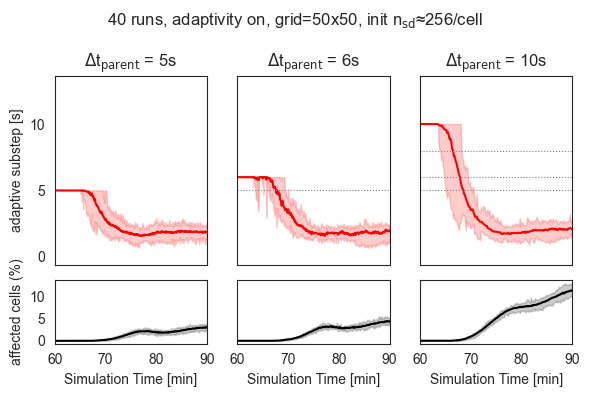

In [ ]:
from collections import defaultdict
fig, axs = plt.subplots(2, len(dts), figsize=(6, 4),gridspec_kw={'height_ratios': [3,1]},sharex=True,sharey=True)
#no grid on the plot
sns.set_style("white")

for idx,dt in enumerate(dts):


    x = np.linspace(0,90,int(90*60/dt+1))
    ax = axs[0,idx]
    grouped_mintstp = defaultdict(list)
    for j in range(iters):
        key = (dt, j, 'adaptive')
        if key in minstep_timeseries:
            grouped_mintstp[dt].append(minstep_timeseries[key])
    mean_min_tstp = np.mean(grouped_mintstp[dt], axis=0)
    std_min_tstp = np.std(grouped_mintstp[dt], axis=0)
    min_min_tstp = np.min(grouped_mintstp[dt], axis=0)
    max_min_tstp = np.max(grouped_mintstp[dt], axis=0)

    ax.plot(x,mean_min_tstp,color='red', label='mean')
    ax.fill_between(x, min_min_tstp, max_min_tstp, color='red',label='ensemble spread', alpha=0.2)
    if dt > 5:
        ax.axhline(y=5, color='grey', linestyle=':',lw=0.8)
    if dt > 6:
        ax.axhline(y=6, color='grey', linestyle=':',lw=0.8)
    if dt > 8:
        ax.axhline(y=8, color='grey', linestyle=':',lw=0.8)
    # ax.set_ylim(1.5, 11)
    ax.set_xlim(60, 90)
    # ax.legend()
    # unicode! approx
   
    ax.set_title(f"$\Delta$t$_\\text{{parent}}$ = {dt}s")
    # ax.set_xlabel("Simulation Time")
    

    axfrac = axs[1,idx]
    grouped_fraction_of_affected_cells = defaultdict(list)
    for j in range(iters):
        key = (dt, j, 'adaptive')
        if key in fraction_of_affected_cells_timeseries:
            grouped_fraction_of_affected_cells[dt].append(fraction_of_affected_cells_timeseries[key])
    mean_fraction_of_affected_cells = np.array(np.mean(grouped_fraction_of_affected_cells[dt], axis=0))
    std_fraction_of_affected_cells = np.array(np.std(grouped_fraction_of_affected_cells[dt], axis=0))
    min_fraction_of_affected_cells = np.array(np.min(grouped_fraction_of_affected_cells[dt], axis=0))
    max_fraction_of_affected_cells = np.array(np.max(grouped_fraction_of_affected_cells[dt], axis=0))

    axfrac.plot(x,mean_fraction_of_affected_cells*100,color='black', label='mean')
    axfrac.fill_between(x, min_fraction_of_affected_cells*100, max_fraction_of_affected_cells*100, color='black',label='ensemble spread', alpha=0.2)
    axfrac.set_yticks([0,5,10])
    axfrac.set_xlim(60, 90)
    # axfrac.legend()
    # unicode! approx
    axfrac.set_xlabel("Simulation Time [min]")

axs[0,0].set_ylabel("adaptive substep [s]")
axs[1,0].set_ylabel("affected cells (%)")

plt.suptitle(f"{iters} runs, adaptivity on, grid = {GRID}\\times{GRID}, init n$_\\text{{sd}}$ ≈ {N_SD_PER_GRID}/cell")
plt.tight_layout()
plt.savefig('minstep_adaptive.pdf')
plt.show()

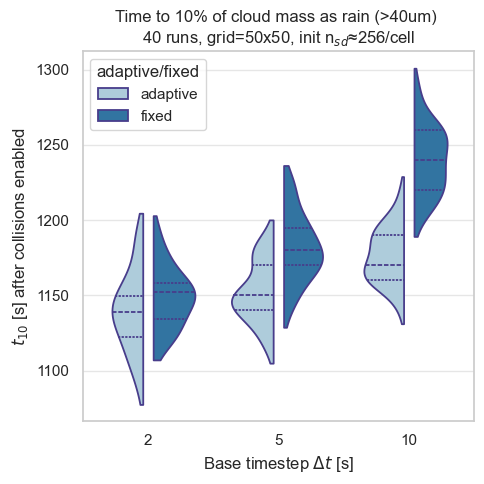

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data for Seaborn
data = []
for key, values in t_10_act_timeseries.items():
    if key[0] not in dts:
        continue
    dt, iteration, adaptivity = key
    first_time_index = np.argmax(np.array(values) > 0.1)
    if first_time_index > 0:  # Ensure it actually exceeds 0.1
        # Check if the next three values are also greater than 0.1 
        if values[first_time_index] > 0.1 and \
           (first_time_index + 1 < len(values) and values[first_time_index + 1] > 0.1) and \
           (first_time_index + 2 < len(values) and values[first_time_index + 1] > 0.1) and \
           (first_time_index + 3 < len(values) and values[first_time_index + 1] > 0.1) and \
           (first_time_index + 4 < len(values) and values[first_time_index + 2] > 0.1):
            # Calculate the first time when the value exceeds 0.1
            first_time = first_time_index * dt
            data.append({
                "dt": dt,
                "adaptive/fixed": adaptivity,
                "value": (first_time - 60 * 60),
            })

# Convert to DataFrame
df = pd.DataFrame(data)

# Plot using Seaborn
sns.set_theme(style="ticks",palette="dark")
sns.set_style('whitegrid',{"grid.color": ".9", "grid.linestyle": "-","grid.linewidth": 0.2})
plt.figure(figsize=(5, 5))
sns.violinplot(df,x="dt", y="value", hue="adaptive/fixed", width=.8,gap=.2,#,width_method="linear",
              linewidth=1.3,split=True,inner="quart", fill=True,linecolor='darkslateblue',
              palette="Paired",cut=1,
)


plt.xlabel("Base timestep $\Delta t$ [s]")
plt.ylabel("$t_{10}$ [s] after collisions enabled")
plt.title(f"Time to 10% of cloud mass as rain (>40um) \n{iters} runs, grid={GRID}x{GRID}, init n$_{{sd}}$≈{N_SD_PER_GRID}/cell")
plt.tight_layout()
plt.savefig(f't_10_{N_SD_PER_GRID}percell.pdf')
plt.show()

In [ ]:
nx_fig8 = GRID
dt_fig8 = dts[2]
sd_cell_fig8 = N_SD_PER_GRID
step_fig8 = 522

settings = Settings()
backend.formulae.seed = 0
settings.grid = (nx_fig8,nx_fig8)
settings.size = (1500 * si.metres, 1500 * si.metres)
settings.n_sd_per_gridbox = sd_cell_fig8
dt = dt_fig8

settings.simulation_time = 90 * si.minute
settings.dt = dt * si.second
settings.spin_up_time = 1 * si.hour
settings.output_interval = dt * si.second
storage_fig8 = Storage()
simulation = Simulation(settings, storage_fig8, SpinUp=SpinUp,backend = backend)
simulation.reinit(products)
setattr(simulation.particulator.dynamics['Collision'], "adaptive", True)     
output = simulation.run(ProgBarController("progress:"), vtk_exporter=None)

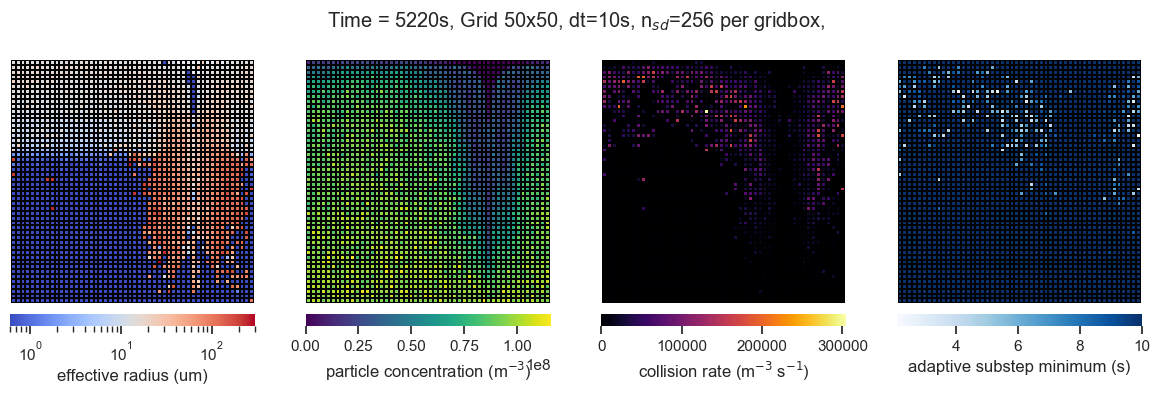

In [ ]:
products_= ['r_eff_all', 'n_all','crpgb','dt_min',]
timekey = 10

fig, ax = plt.subplot_mosaic([products_],
    sharex=True, sharey=True,figsize=(12,4),tight_layout=True,)

cmaps = {
    'dt_min': 'Blues',
    'crpgb': 'inferno',
    'r_eff_all': 'coolwarm',
    'n_all': 'viridis',
}
labels = {
    'dt_min': 'adaptive substep minimum (s)',
    'crpgb': 'collision rate (m$^{-3}$ s$^{-1}$)',
    'r_eff_all': 'effective radius (um)',
    'n_all': 'particle concentration (m$^{-3}$)',
}
for product_, ax in ax.items():
    hm_data = storage_fig8.load(name=product_, step=step_fig8)
    hm_data = np.rot90(hm_data,k=1)
    norm=mcolors.LogNorm(vmin=0.6, vmax=300) if product_ == 'r_eff_all' else None
    sns.heatmap(hm_data, ax=ax, cbar=True,cbar_kws={'orientation':'horizontal',
                                                    'label':labels[product_], 
                                                    'fraction':0.046, 
                                                    'pad':0.04,
                                                    'format':'%.2e' if product_ =='crpgb' else None
                                                    },
                                                    xticklabels=False, yticklabels=False,
                                                    square=True,
                                                    cmap=cmaps[product_],norm=norm,linewidth=0.1,
                                                    linecolor='black',
                                                    )
    
plt.suptitle(f"Time = {step_fig8*dt_fig8}s, Grid {nx_fig8}x{nx_fig8}, dt={dt_fig8}s, n$_{{sd}}$={sd_cell_fig8} per gridbox,")
plt.savefig(f'snapshot_dt{dt_fig8}.pdf')